# Masking with sequence speckling doesn't impact fitted temporal bases

**tl;dr.**
Cross-validation with sequence speckled masking and vanilla masking both agree that there are only 2-4 intra-session temporal factors for the data binned at 1 minute.
Both cross-validation schemes find that factors form a Gaussian basis set distributed along the within-session time axis.
This suggests that the longer sequence speckeld masking is not inadvertently obscuring finer temporal dyamics.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from tqdm.auto import tqdm
import itertools
import numpy as onp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from dtd.data import load_wiltschko22_data
from dtd.utils import (
    create_block_speckled_mask,
    download_wnb_params,
    get_wnb_project_df
)
from dtd.viz import plot_buffered_mask

## Visualize block speckled mask

In [2]:
rng = onp.random.default_rng(seed=0)

mask_shape = (50,20)
frac_mask = 0.20
sequence_speckle_params = dict(
    block_shape=(1,3),
    buffer_size=(0,1),
    frac_include_buffer=False,
)

vanilla_speckle_params = dict(
    block_shape=(1,1),
    buffer_size=(0,0),
    frac_include_buffer=False,
)

# -----------------------------------------------------------------------
# Construct masks 
sequence_masks = create_block_speckled_mask(
    rng, mask_shape, frac_mask=frac_mask,
    **sequence_speckle_params
)  # Holdout and buffer masks, both shape (n_train, n_timebins)

vanilla_masks = create_block_speckled_mask(
    rng, mask_shape, frac_mask=frac_mask,
    **vanilla_speckle_params
)  # Holdout and buffer masks, both shape (n_train, n_timebins)


Text(0.5, 1.1, 'speckled masking schemes, 20% holdout')

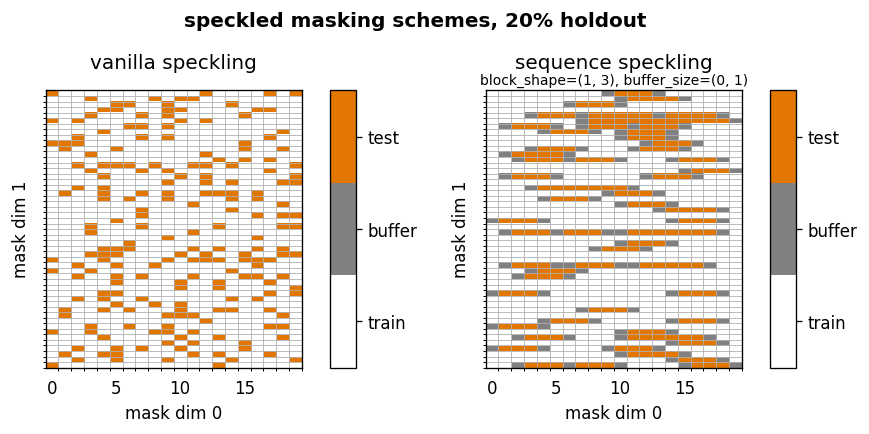

In [3]:
ydim, xdim = mask_shape
subtitle_kwargs = dict(fontsize='large', y=1.03, va='bottom')

fig = plt.figure(figsize=(7,3), dpi=120)
vanilla_subfig, sequence_subfig = fig.subfigures(ncols=2, wspace=0.1)

plot_buffered_mask(*vanilla_masks, max_sessions_per_col=50, fig=vanilla_subfig)
vanilla_ax = vanilla_subfig.axes[0]
vanilla_ax.set_title("vanilla speckling", **subtitle_kwargs)

plot_buffered_mask(*sequence_masks, max_sessions_per_col=50, fig=sequence_subfig)
sequence_ax = sequence_subfig.axes[0]
sequence_ax.set_title(f"sequence speckling", **subtitle_kwargs)
sequence_ax.text(
    0.5, 1.01,
    f"block_shape={sequence_speckle_params['block_shape']}, buffer_size={sequence_speckle_params['buffer_size']}",
    ha='center', va='bottom',
    fontsize='small', transform=sequence_ax.transAxes,
)

for ax in (vanilla_ax, sequence_ax):
    ax.set_xticks(onp.arange(xdim)+0.5, minor=True)
    ax.set_yticks(onp.arange(ydim)+0.5, minor=True)
    ax.tick_params(bottom=False, left=False)
    ax.grid(which='minor', lw=0.5)

    ax.set_xlabel('mask dim 0')
    ax.set_ylabel('mask dim 1')

fig.suptitle(f"speckled masking schemes, {int(frac_mask*100)}% holdout", y=1.1, fontsize='large', fontweight='bold')



## Results

In this section, we evaluate the held-out log-likelihood vs. model ranks as a function of masking scheme. We will inspect the curves to select the most parsimonious model.

### Vanilla speckled masking

In [6]:
# Load results
wnb_entity = 'eyz'
config_keys = ['k1', 'k2', 'k3']
summary_keys = ['avg_test_ll']

vanilla_project = 'moseq-dtd-sweep-20250211-vanilla-speckle-2'
vanilla_df = get_wnb_project_df(wnb_entity, vanilla_project, config_keys, summary_keys)

vanilla_df

,id,name,k1,k2,k3,avg_test_ll
0,iuhzrwf8,radiant-morning-1,5,2,5,-23.619841
1,166ttatw,deft-snow-2,5,2,10,-22.029284
2,bfswvx78,desert-star-3,5,2,20,-21.957026
3,emmr00t1,fragrant-flower-4,5,2,30,-22.135607
4,xoiyzudc,skilled-fog-5,5,2,40,-22.135395
...,...,...,...,...,...,...
361,asrcn0bz,cosmic-resonance-362,5,2,10,-21.798906
362,gq3ij8dt,wobbly-water-363,5,2,20,-21.491312
363,5rx2tqta,legendary-morning-364,5,2,30,-21.710381
364,kgai54pp,royal-snowball-365,5,2,40,-21.488428


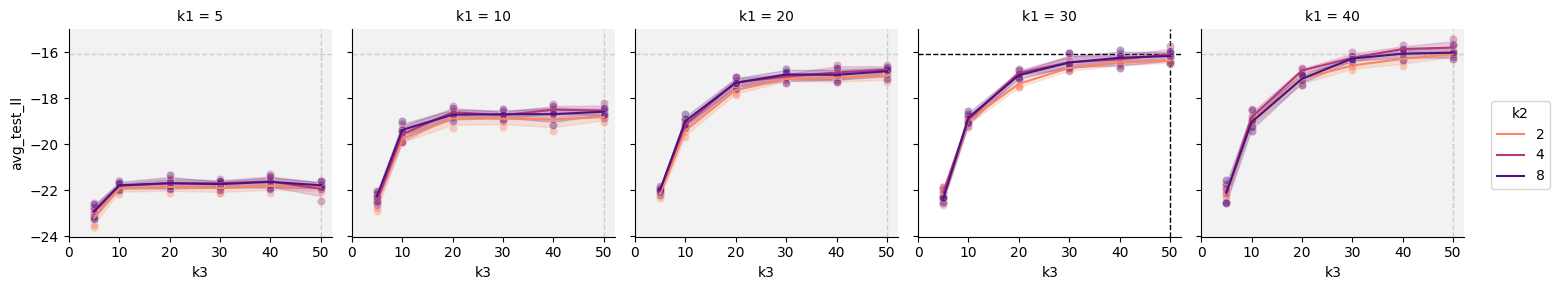

In [7]:
# choose which variables/ranks to place on which plotting dimension
col_var, hue_var, x_var = "k1", "k2", "k3"
# col_var, hue_var, x_var = "k2", "k1", "k3"
# col_var, hue_var, x_var = "k2", "k3", "k1"

# based on inspection, we choose the following rank
selected_rank = dict(
    k1 = 30, k2 = 4, k3 = 50,
)

# Mean ll of selection (group by and agg are difficult to work with)
mask = (vanilla_df[col_var] == selected_rank[col_var]) & (vanilla_df[hue_var] == selected_rank[hue_var]) & (vanilla_df[x_var] == selected_rank[x_var])
selected_ll_mean = vanilla_df[mask]['avg_test_ll'].mean()

# Index of selected column
i_col = (onp.argwhere(vanilla_df[col_var].unique() == selected_rank[col_var])).item()

# ----------------------------------------------------------------------------
g = sns.FacetGrid(vanilla_df, col=col_var, hue=hue_var, palette="magma_r")
g.map(sns.lineplot, x_var, "avg_test_ll")
g.add_legend(frameon=True)
g.map(sns.scatterplot, x_var, "avg_test_ll", markers='.', alpha=0.4)

for i, ax in enumerate(g.axes.ravel()):
    ax.set_xlim(left=0)

    c = 'k' if i == i_col else '0.8' 
    ax.axvline(selected_rank[x_var], c=c, ls='--', lw=1, zorder=0)
    ax.axhline(selected_ll_mean, c=c, ls='--', lw=1, zorder=0)

    if i != i_col:
        ax.set_facecolor('0.95')


plt.show()

When cross-validation with vanilla speckled masking, the held-out log likelihood curves vs model ranks suggest a rank of around (30, 4, 50).

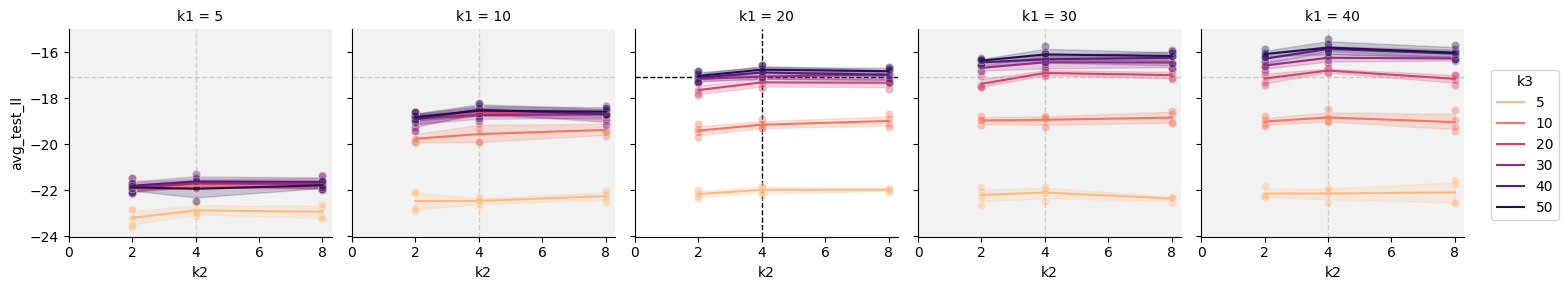

In [8]:
# choose which variables/ranks to place on which plotting dimension
col_var, hue_var, x_var = "k1", "k3", "k2"

# based on inspection, we choose the following rank
selected_rank = dict(
    k1 = 20, k2 = 4, k3 = 30,
)

# Mean ll of selection (group by and agg are difficult to work with)
mask = (vanilla_df[col_var] == selected_rank[col_var]) & (vanilla_df[hue_var] == selected_rank[hue_var]) & (vanilla_df[x_var] == selected_rank[x_var])
selected_ll_mean = vanilla_df[mask]['avg_test_ll'].mean()

# Index of selected column
i_col = (onp.argwhere(vanilla_df[col_var].unique() == selected_rank[col_var])).item()

# ----------------------------------------------------------------------------
g = sns.FacetGrid(vanilla_df, col=col_var, hue=hue_var, palette="magma_r")
g.map(sns.lineplot, x_var, "avg_test_ll")
g.add_legend(frameon=True)
g.map(sns.scatterplot, x_var, "avg_test_ll", markers='.', alpha=0.4)

for i, ax in enumerate(g.axes.ravel()):
    ax.set_xlim(left=0)

    c = 'k' if i == i_col else '0.8' 
    ax.axvline(selected_rank[x_var], c=c, ls='--', lw=1, zorder=0)
    ax.axhline(selected_ll_mean, c=c, ls='--', lw=1, zorder=0)

    if i != i_col:
        ax.set_facecolor('0.95')


plt.show()

Here, we've plotted the same curves but with the number of intra-session factors, $K_2$, along the x-axis. We see that the held-out-log likelihoods stay relatively flat, indicating that increasing the number of intra-session factors does not contribute to minimizing reconstruction error. There is a slight maximum at $K_2=4$, so we select this value.

## Sequence speckled masking

In [9]:
# Load results
wnb_entity = 'eyz'
sequence_project = 'moseq-dtd-sweep-20250130-speckle-only'

config_keys = ['k1', 'k2', 'k3']
summary_keys = ['avg_test_ll']

sequence_df = get_wnb_project_df(wnb_entity, sequence_project, config_keys, summary_keys)

sequence_df

,id,name,k1,k2,k3,avg_test_ll
0,bf89l2xg,bumbling-resonance-1,5,2,5,-23.701851
1,0kfwvagh,solar-blaze-2,5,2,10,-21.986660
2,xs886dzg,dazzling-sun-3,5,2,20,-22.284842
3,eourunsv,chocolate-field-4,5,2,30,-22.287405
4,9kqfrnxl,fresh-sponge-5,5,2,40,-21.978079
...,...,...,...,...,...,...
445,5dnxoc92,happy-smoke-446,40,8,10,-19.676674
446,ti8d88h7,desert-frog-447,40,8,20,-18.455303
447,rvpcremu,fancy-haze-448,40,8,30,-17.693424
448,pn0s5fyv,azure-gorge-449,40,8,40,-18.247656


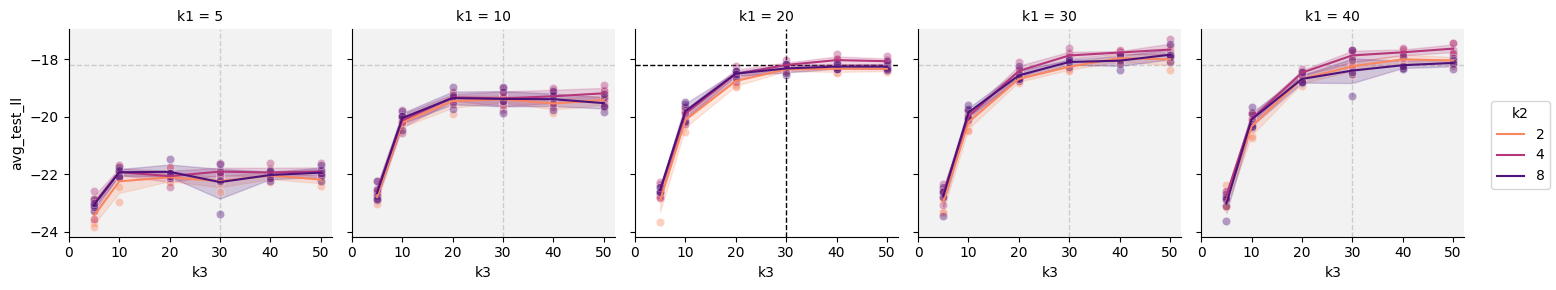

In [10]:
# choose which variables/ranks to place on which plotting dimension
col_var, hue_var, x_var = "k1", "k2", "k3"
# col_var, hue_var, x_var = "k2", "k1", "k3"
# col_var, hue_var, x_var = "k2", "k3", "k1"

# based on inspection, we choose the following rank
selected_rank = dict(
    k1 = 20, k2 = 4, k3 = 30,
)

# Mean ll of selection (group by and agg are difficult to work with)
mask = (sequence_df[col_var] == selected_rank[col_var]) & (sequence_df[hue_var] == selected_rank[hue_var]) & (sequence_df[x_var] == selected_rank[x_var])
selected_ll_mean = sequence_df[mask]['avg_test_ll'].mean()

# Index of selected column
i_col = (onp.argwhere(sequence_df[col_var].unique() == selected_rank[col_var])).item()

# ----------------------------------------------------------------------------
g = sns.FacetGrid(sequence_df, col=col_var, hue=hue_var, palette="magma_r")
g.map(sns.lineplot, x_var, "avg_test_ll")
g.add_legend(frameon=True)
g.map(sns.scatterplot, x_var, "avg_test_ll", markers='.', alpha=0.4)

for i, ax in enumerate(g.axes.ravel()):
    ax.set_xlim(left=0)

    c = 'k' if i == i_col else '0.8' 
    ax.axvline(selected_rank[x_var], c=c, ls='--', lw=1, zorder=0)
    ax.axhline(selected_ll_mean, c=c, ls='--', lw=1, zorder=0)

    if i != i_col:
        ax.set_facecolor('0.95')


plt.show()

When cross-validation with sequence speckled masking, the held-out log likelihood curves vs model ranks suggest a rank of around (20, 4, 30).

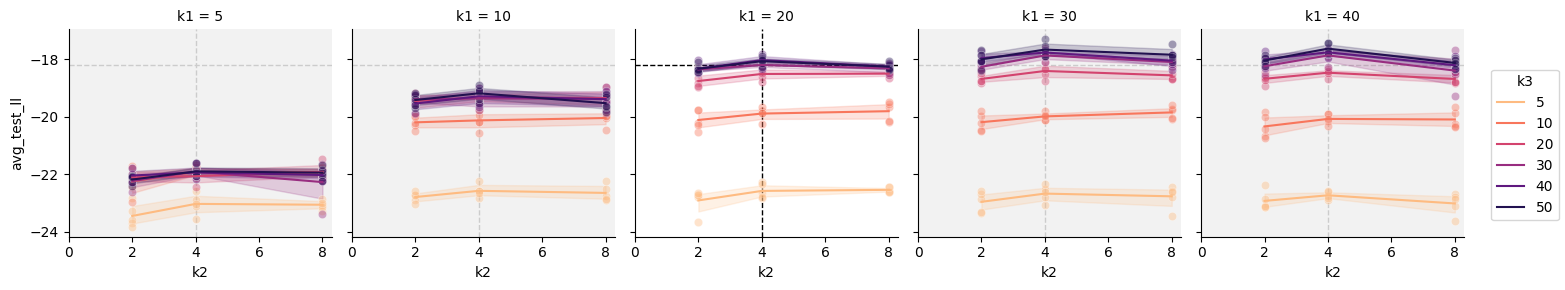

In [11]:
# choose which variables/ranks to place on which plotting dimension
col_var, hue_var, x_var = "k1", "k3", "k2"

# based on inspection, we choose the following rank
selected_rank = dict(
    k1 = 20, k2 = 4, k3 = 30,
)

# Mean ll of selection (group by and agg are difficult to work with)
mask = (sequence_df[col_var] == selected_rank[col_var]) & (sequence_df[hue_var] == selected_rank[hue_var]) & (sequence_df[x_var] == selected_rank[x_var])
selected_ll_mean = sequence_df[mask]['avg_test_ll'].mean()

# Index of selected column
i_col = (onp.argwhere(sequence_df[col_var].unique() == selected_rank[col_var])).item()

# ----------------------------------------------------------------------------
g = sns.FacetGrid(sequence_df, col=col_var, hue=hue_var, palette="magma_r")
g.map(sns.lineplot, x_var, "avg_test_ll")
g.add_legend(frameon=True)
g.map(sns.scatterplot, x_var, "avg_test_ll", markers='.', alpha=0.4)

for i, ax in enumerate(g.axes.ravel()):
    ax.set_xlim(left=0)

    c = 'k' if i == i_col else '0.8' 
    ax.axvline(selected_rank[x_var], c=c, ls='--', lw=1, zorder=0)
    ax.axhline(selected_ll_mean, c=c, ls='--', lw=1, zorder=0)

    if i != i_col:
        ax.set_facecolor('0.95')


plt.show()

Again, we plot the held-out log likelihoods with the number of intra-session factors, $K_2$ along the x-axis. Again, we see that the held-out-log likelihoods stay relatively flat, indicating that increasing the number of intra-session factors does not contribute to minimizing reconstruction error. There is a slight maximum at $K_2=4$, so we select this value.

## Conclusions
Unsurprisingly, cross-validation with the stricter sequence speckled masking suggests a smaller model of ranks (20,4,30), versus the model rank suggested by vanilla speckling of (30,4,50).

Both masking schemes, however, agree that there there is no significant differences in model reconstruction performance with larger values of $K_2$ (number of intra-session factors).
There is the slightest maximum at $K_2=4$ in both cases, which corresponds to the model fitting a linearly spaced Gaussian basis functions along that mode (see below).

However, it is worth noting that while model reconstruction is not sensitive to the number of intra-session factors, it may still be beneficial for predictive performance to increase the value of $K_2$. We explore this in a later notebook.

In [12]:
import jax.numpy as jnp
import jax.random as jr
from dtd.data import load_wiltschko22_data
from dtd.model3d import DirichletTuckerDecomp
from dtd.viz import set_time_within_session_ticks

# Load data
filepath = "/home/groups/swl1/eyz/data/moseq-drugs/syllable_binned_1min.npz"
X, batch_axes, event_axes, metadata = load_wiltschko22_data(filepath)

d1, d2, d3 = n_sessions, n_timebins, n_syllables = X.shape
batch_shape = X.shape[:len(batch_axes)]

X = jnp.asarray(X, dtype=float)
total_counts = int(X.sum(event_axes).ravel()[0])
assert jnp.all(X.sum(event_axes) == total_counts)

In [13]:
k1, k2, k3 = 20, 4, 30

key = jr.key(0)
init_key, stem_key, = jr.split(key)  # stem_key used for stochastic em

# Instantiate model and initialize parameters
model = DirichletTuckerDecomp(total_counts, k1, k2, k3, alpha=1.1)
init_params = model.sample_params(init_key, d1, d2, d3, conc=0.5)

dummy_mask = jnp.ones(batch_shape, dtype=bool)
params, lps = model.fit(X, dummy_mask, init_params, num_iters=500, wnb=None)

  0%|          | 0/500 [00:00<?, ?it/s]

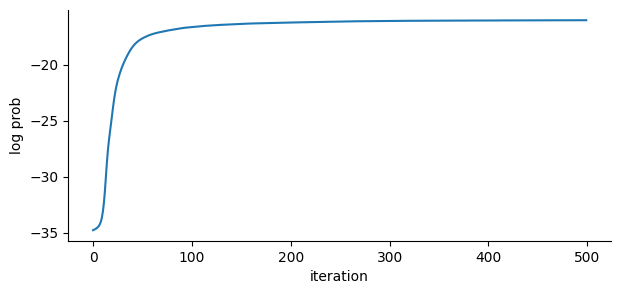

In [14]:
plt.figure(figsize=(7,3))
plt.plot(lps / X.size)
plt.xlabel('iteration')
plt.ylabel('log prob')
sns.despine()

Text(0.5, 1.1, 'temporal factors vs. time bin')

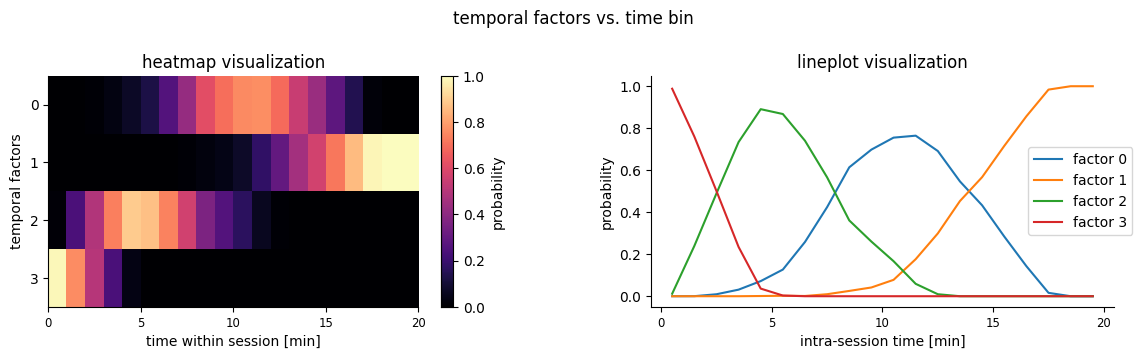

In [23]:
temporal_factors = params[2]

fig = plt.figure(figsize=(12,3))
heatmap_subfig, lineplot_subfig = fig.subfigures(ncols=2, wspace=0.1)

# --------------------------------------------------------------------------------------------------
# heatmap
ax = heatmap_subfig.add_subplot(1,1,1)
im = ax.imshow(temporal_factors.T, cmap='magma', clim=(0,1), interpolation='none', aspect='auto',)
plt.colorbar(im, label='probability')

# Label x-axis
set_time_within_session_ticks(
    d2, metadata['frames_per_bin'], metadata['frames_per_sec'], tick_period=5, tick_units='min', ax=ax
)
ax.set_xlabel(f"time within session [min]")
ax.tick_params(axis='x', labelsize='small')

# Label y-axis
ax.set_yticks(range(k2))
ax.set_ylabel("temporal factors")

ax.set_title('heatmap visualization')

# --------------------------------------------------------------------------------------------------
# lineplot
ax = lineplot_subfig.add_subplot(1,1,1)

for k in range(k2):
    ax.plot(temporal_factors[:,k], label=f'factor {k}')
ax.legend(loc='center left', bbox_to_anchor=[0.8, 0.5])

set_time_within_session_ticks(
    d2, metadata['frames_per_bin'], metadata['frames_per_sec'], tick_period=5, tick_units='min', ax=ax,
)
ax.set_xlabel(f"intra-session time [min]")
ax.tick_params(axis='x', labelsize='small')

ax.set_ylabel('probability')
ax.set_title('lineplot visualization')

sns.despine()

fig.suptitle("temporal factors vs. time bin", fontsize='large', y=1.1)

The model learns approximate Gaussian basis functions as its intra-session temporal factors for the moseq-drug dataset (1 minute bin).